# Message passing neural network for segment classification on ACTS data

In this notebook we'll implement a model similar to the Interaction Networks model:
https://arxiv.org/abs/1612.00222

The model will consider a graph of connected hits and try to determine which edges are real and which are spurious.

In [1]:
# Training concurrency
import os
os.environ['OMP_NUM_THREADS'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

cuda = True

In [2]:
%load_ext autoreload
%autoreload 2

# System imports
from __future__ import print_function
import os
import multiprocessing as mp
from timeit import default_timer as timer

# Externals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.model_selection import train_test_split

# Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if cuda else "cpu")

# Local imports
from acts import process_hits_files, select_barrel_hits, select_hits
from graph import load_graphs, SparseGraph, graph_from_sparse
from model_maskedlinear import SegmentClassifier
from estimator_maskedlinear import Estimator

feature_scale = np.array([1000., np.pi/8, 1000.])

n_features = feature_scale.shape[0]
print(feature_scale)

%matplotlib inline

[1.00000000e+03 3.92699082e-01 1.00000000e+03]


In [3]:
if cuda:
    np_to_torch = lambda x, volatile=False, dtype=np.float32: (torch.tensor(x.astype(dtype), requires_grad=False).cuda())
else:
    np_to_torch = lambda x, volatile=False, dtype=np.float32: (torch.tensor(x.astype(dtype), requires_grad=False))

if cuda:
    torch_to_np = lambda x: x.cpu().numpy()
else:
    torch_to_np = lambda x: x.detach().numpy()

## Data utilities

## Prepare the data

In [4]:
#input_dir = '/data/ntran/prod_mu10_pt1000_2017_07_29'
#input_dir = '/cms-sc17/graphNN/prod_mu10_pt1000_2017_07_29'
input_dir = '/home/ec2-user/gnn-fpga/gnn/graphs_n-tracks10_z0-max400_phi-slope-max0p002_no-missing-hits/'

In [5]:
%%time
n_samples = 14160
filenames = [os.path.join(input_dir, 'graph%06i.npz' % i) for i in range(n_samples)]
graphs = load_graphs(filenames, SparseGraph)
print(len(graphs))

14160
CPU times: user 31.4 s, sys: 488 ms, total: 31.9 s
Wall time: 31.9 s


In [6]:
# Get the mean label for all the segments from all samples

# Flatten the labels array
flat_y = np.concatenate([g.y for g in graphs])

flat_y.mean()
#for i in len(flat_y):
#    if 


0.3614505

## Define the data generator

Since every event is unique, we need something which can batch things together into batch-specific tensors.

It should just use the max size required for that sample.

In [7]:
def merge_graphs(graphs):
    batch_size = len(graphs)
    
    # Special handling of batch size 1
    if batch_size == 1:
        g = graphs[0]
        # Prepend singleton batch dimension
        return g.X[None], g.Ri[None], g.Ro[None], g.y[None]
    
    # Get the maximum sizes in this batch
    n_features = graphs[0].X.shape[1]
    n_nodes = np.array([g.X.shape[0] for g in graphs])
    n_edges = np.array([g.y.shape[0] for g in graphs])
    max_nodes = n_nodes.max()
    max_edges = n_edges.max()

    # Allocate the tensors for this batch
    batch_X = np.zeros((batch_size, max_nodes, n_features), dtype=np.float32)
    batch_Ri = np.zeros((batch_size, max_nodes, max_edges), dtype=np.uint8)
    batch_Ro = np.zeros((batch_size, max_nodes, max_edges), dtype=np.uint8)
    batch_y = np.zeros((batch_size, max_edges), dtype=np.uint8)

    # Loop over samples and fill the tensors
    for i, g in enumerate(graphs):
        batch_X[i, :n_nodes[i]] = g.X
        batch_Ri[i, :n_nodes[i], :n_edges[i]] = g.Ri
        batch_Ro[i, :n_nodes[i], :n_edges[i]] = g.Ro
        batch_y[i, :n_edges[i]] = g.y
    
    return batch_X, batch_Ri, batch_Ro, batch_y

def batch_generator(graphs, n_samples=1, batch_size=1, train=True):
    volatile = not train
    batch_idxs = np.arange(0, n_samples, batch_size)
    # Loop over epochs
    while True:
        # Loop over batches
        for j in batch_idxs:
            #print('batch', j, '-', j+batch_size)
            batch_graphs = [graph_from_sparse(g) for g in graphs[j:j+batch_size]]
            batch_X, batch_Ri, batch_Ro, batch_y = merge_graphs(batch_graphs)
            #print('  graphs merged')
            batch_inputs = [
                np_to_torch(batch_X, volatile=volatile),
                np_to_torch(batch_Ri, volatile=volatile),
                np_to_torch(batch_Ro, volatile=volatile)]
            batch_target = np_to_torch(batch_y, volatile=volatile)
            #print('  data prepared')
            yield batch_inputs, batch_target

### Visualize one sample

Need to put this code into a function, and write it so it will be easy to use
at model evaluation time (e.g., using model representation of the data).

In [27]:
def draw_sample(X, Ri, Ro, y, cmap='bwr_r', alpha_labels=False):
    """
    TODO: make segment coloring configurable.
    """
    # Select the i/o node features for each segment
    feats_o = X[np.where(Ri.T)[1]]
    feats_i = X[np.where(Ro.T)[1]]
    # Prepare the figure
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9,4))
    cmap = plt.get_cmap(cmap)
    
    # Draw the hits (r, phi, z)
    ax0.scatter(X[:,2], X[:,0], c='k')
    ax1.scatter(X[:,1], X[:,0], c='k')
    
    # Draw the segments
    for j in range(y.shape[0]):
        if alpha_labels:
            seg_args = dict(c='k', alpha=float(y[j]))
        else:
            seg_args = dict(c=cmap(float(y[j])))
        ax0.plot([feats_o[j,2], feats_i[j,2]],  
                 [feats_o[j,0], feats_i[j,0]], '-', **seg_args)
        ax1.plot([feats_o[j,1], feats_i[j,1]],
                 [feats_o[j,0], feats_i[j,0]], '-', **seg_args)
    # Adjust axes
    #ax0.set_xlim(-1100, 1100)
    ax1.set_xlim(-np.pi/8, np.pi/8)
    ax0.set_xlabel('$z$ [mm]')
    ax1.set_xlabel('$\phi$ [rad]')
    ax0.set_ylabel('$r$ [mm]')
    ax1.set_ylabel('$r$ [mm]')
    plt.tight_layout()
    
    print(X)
    


[[ 3.16039659e+01 -1.58459986e-01  1.19018005e+01]
 [ 7.25891590e+01 -1.64602849e-01  2.85099000e+01]
 [ 1.16177045e+02 -1.14681332e-01  4.85483035e+01]
 [ 1.70899153e+02 -1.49863575e-01  5.05542979e+01]
 [ 2.59983182e+02 -2.02544542e-01  4.14000005e+01]
 [ 3.62204134e+02 -2.12032889e-01  2.70000007e+01]
 [ 5.02530754e+02 -1.78309292e-01 -1.37999998e+01]
 [ 6.61583304e+02 -1.48894164e-01 -1.39300004e+02]
 [ 8.21563482e+02 -8.17888649e-02 -2.71200001e+02]
 [ 1.02148688e+03  4.12518087e-02 -4.17400002e+02]
 [ 3.16656455e+01 -1.75975656e-01  1.17818005e+01]
 [ 7.27746338e+01 -1.76439846e-01  2.71537993e+01]
 [ 1.15261637e+02 -1.77215661e-01  4.30577025e+01]
 [ 1.71449989e+02 -1.78285206e-01  6.40890002e+01]
 [ 2.57673025e+02 -1.80067871e-01  9.64000002e+01]
 [ 3.61139387e+02 -1.81976652e-01  1.34800002e+02]
 [ 5.02014637e+02 -1.84678170e-01  1.87399998e+02]
 [ 6.60463333e+02 -1.87863914e-01  2.47400001e+02]
 [ 8.20940852e+02 -1.90899937e-01  3.03600013e+02]
 [ 1.02340961e+03 -1.94827170e-

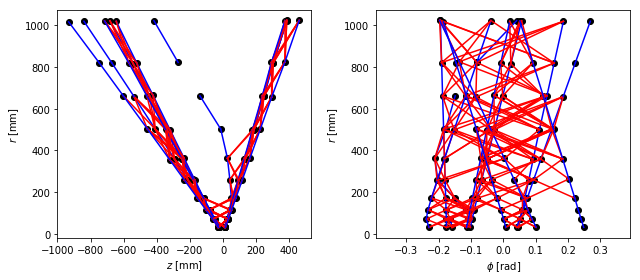

In [28]:
# Pull the inputs from the batcher
g = graph_from_sparse(graphs[0])
draw_sample(g.X*feature_scale, g.Ri, g.Ro, g.y)

In [22]:
'''edges = []
for g in graphs:
    g = graph_from_sparse(g)
    n_edge = g.Ro.shape[1]
    edges.append(n_edge)
bins = np.linspace(min(edges), 
                   max(edges),
                   35)    
plt.hist(edges, bins=bins)
plt.title('Edge Distribution')
plt.xlabel('Edges per Event')
plt.ylabel('Frequency')

plt.show()

print("Average:", round(np.mean(edges), 1), "Standard Deviation:", round(np.std(edges), 1)) '''

'edges = []\nfor g in graphs:\n    g = graph_from_sparse(g)\n    n_edge = g.Ro.shape[1]\n    edges.append(n_edge)\nbins = np.linspace(min(edges), \n                   max(edges),\n                   35)    \nplt.hist(edges, bins=bins)\nplt.title(\'Edge Distribution\')\nplt.xlabel(\'Edges per Event\')\nplt.ylabel(\'Frequency\')\n\nplt.show()\n\nprint("Average:", round(np.mean(edges), 1), "Standard Deviation:", round(np.std(edges), 1)) '

## Train the model

In [8]:
# Model config
hidden_dim = 8
n_iters = 4

# Training config
batch_size = 32

n_epochs = 100
valid_frac = 0.2
test_frac = 0.2

In [9]:
# We round by batch_size to avoid partial batches
n_test = int(n_samples * test_frac) // batch_size * batch_size
n_valid = int(n_samples * valid_frac) // batch_size * batch_size
n_train = (n_samples - n_valid - n_test) // batch_size * batch_size
n_train_batches = n_train // batch_size
n_valid_batches = n_valid // batch_size
n_test_batches = n_test #// batch_size

n_train, n_valid, n_test, n_train + n_valid + n_test

(8512, 2816, 2816, 14144)

In [10]:
# Partition the dataset
train_graphs, test_graphs = train_test_split(graphs, test_size=n_test)
train_graphs, valid_graphs = train_test_split(train_graphs, test_size=n_valid)

print('Train set size:', len(train_graphs))
print('Valid set size:', len(valid_graphs))
print('Test set size: ', len(test_graphs))

Train set size: 8528
Valid set size: 2816
Test set size:  2816


In [11]:
# Prepare the batch generators
train_batcher = batch_generator(train_graphs, n_samples=n_train, batch_size=batch_size)
valid_batcher = batch_generator(valid_graphs, n_samples=n_valid, batch_size=batch_size, train=False)

In [46]:
threshold = .01
%matplotlib inline

model = SegmentClassifier(input_dim=n_features, hidden_dim=hidden_dim, n_iters=n_iters, masks_e=None, masks_n=None)
loss_func = nn.BCELoss()
estim = Estimator(model, loss_func=loss_func, cuda=cuda, l1 = 0)
estim.load_checkpoint('Trainings/hid8l14mask35round2_ldweights.pt')

def summer(arr, net_name):
    arr_f = arr.flatten()
    sum_n = sum(arr_f)
    print(net_name, 'Network Sum:', sum_n)

with torch.no_grad():
    # Edge Networks
    #print(model.edge_network.network[0].weight)
    #print(model.edge_network.network[0].weight.shape)
    arr_e = torch_to_np(model.edge_network.network[0].weight)
    arr_e = (np.abs(arr_e) > threshold)*1
    summer(arr_e, 'Edge')


    arr_e2 = torch_to_np(model.edge_network.network[2].weight)
    arr_e2 = (np.abs(arr_e2) > threshold)*1
    summer(arr_e2, 'Edge2')
    
    
    # Node Networks
    arr_n = torch_to_np(model.node_network.network[0].weight)
    #print(model.node_network.network[0].weight.shape)
    arr_n = (np.abs(arr_n) > threshold)*1
    summer(arr_n, 'Node')

    
    arr_n2 = torch_to_np(model.node_network.network[2].weight)
    #print(model.node_network.network[2].weight.shape)
    arr_n2 = (np.abs(arr_n2) > threshold)*1
    summer(arr_n2, 'Node2')
    
    mask_e = [np_to_torch(arr_e), np_to_torch(arr_e2)]
    mask_n = [np_to_torch(arr_n), np_to_torch(arr_n2)]

2018-08-01 21:29:23.388829 Model: 
SegmentClassifier(
  (input_network): Sequential(
    (0): Linear(in_features=3, out_features=8, bias=True)
    (1): Tanh()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): MaskedLinear(in_features=22, out_features=8, bias=True)
      (1): Tanh()
      (2): MaskedLinear(in_features=8, out_features=1, bias=True)
      (3): Sigmoid()
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): MaskedLinear(in_features=33, out_features=8, bias=True)
      (1): Tanh()
      (2): MaskedLinear(in_features=8, out_features=8, bias=True)
      (3): Tanh()
    )
  )
)
2018-08-01 21:29:23.389454 Parameters: 569
Edge Network Sum: 86
Edge2 Network Sum: 8
Node Network Sum: 183
Node2 Network Sum: 56


In [47]:
# Construct the model
model = SegmentClassifier(input_dim=n_features, hidden_dim=hidden_dim, n_iters=n_iters, masks_e=mask_e, masks_n=mask_n)
loss_func = nn.BCELoss()
estim = Estimator(model, loss_func=loss_func, cuda=cuda, l1= 0.0001)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
2018-08-01 21:29:25.521545 Model: 
SegmentClassifier(
  (input_network): Sequential(
    (0): Linear(in_features=3, out_features=8, bias=True)
    (1): Tanh()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): MaskedLinear(in_features=22, out_features=8, bias=True)
      (1): Tanh()
      (2): MaskedLinear(in_features=8, out_features=1, bias=True)
      (3): Sigmoid()
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): MaskedLinear(in_features=33, out_features=8, bias=True)
      (1): Tanh()
      (2): MaskedLinear(in_features=8, out_features=8, bias=True)
      (3): Tanh()
    )
  )
)
2018-08-01 21:29:25.521964 Parameters: 569


In [48]:
estim.load_weights('Trainings/hid8l14mask35round2_ldweights.pt')

In [49]:
estim.fit_gen(train_batcher, n_batches=n_train_batches, n_epochs=100,
              valid_generator=valid_batcher, n_valid_batches=n_valid_batches, 
              filename='Trainings/hid8l14mask35round3_ldweights.pt')

2018-08-01 21:29:35.022480 Epoch 0
2018-08-01 21:29:40.131727   training loss 0.473 time 5.10907s
2018-08-01 21:29:40.978005   validate loss 0.217
2018-08-01 21:29:40.978499  save checkpoint
2018-08-01 21:29:40.980737 Epoch 1
2018-08-01 21:29:45.954090   training loss 0.209 time 4.97328s
2018-08-01 21:29:46.800506   validate loss 0.163
2018-08-01 21:29:46.800616  save checkpoint
2018-08-01 21:29:46.803272 Epoch 2
2018-08-01 21:29:51.790761   training loss 0.168 time 4.98727s
2018-08-01 21:29:52.648787   validate loss 0.132
2018-08-01 21:29:52.649273  save checkpoint
2018-08-01 21:29:52.651561 Epoch 3
2018-08-01 21:29:57.655150   training loss 0.147 time 5.00351s
2018-08-01 21:29:58.512466   validate loss 0.12
2018-08-01 21:29:58.512575  save checkpoint
2018-08-01 21:29:58.515235 Epoch 4
2018-08-01 21:30:03.569700   training loss 0.137 time 5.05439s
2018-08-01 21:30:04.424699   validate loss 0.111
2018-08-01 21:30:04.425242  save checkpoint
2018-08-01 21:30:04.427511 Epoch 5
2018-08-01 

2018-08-01 21:33:51.879713   training loss 0.101 time 4.96706s
2018-08-01 21:33:52.727685   validate loss 0.0801
2018-08-01 21:33:52.727812  save checkpoint
2018-08-01 21:33:52.731164 Epoch 44
2018-08-01 21:33:57.694647   training loss 0.101 time 4.96339s
2018-08-01 21:33:58.540849   validate loss 0.08
2018-08-01 21:33:58.540976  save checkpoint
2018-08-01 21:33:58.543900 Epoch 45
2018-08-01 21:34:03.534598   training loss 0.101 time 4.99061s
2018-08-01 21:34:04.381852   validate loss 0.0799
2018-08-01 21:34:04.381977  save checkpoint
2018-08-01 21:34:04.384832 Epoch 46
2018-08-01 21:34:09.365536   training loss 0.101 time 4.98063s
2018-08-01 21:34:10.210730   validate loss 0.0798
2018-08-01 21:34:10.210838  save checkpoint
2018-08-01 21:34:10.213521 Epoch 47
2018-08-01 21:34:15.183660   training loss 0.101 time 4.96992s
2018-08-01 21:34:16.025264   validate loss 0.0797
2018-08-01 21:34:16.025839  save checkpoint
2018-08-01 21:34:16.028075 Epoch 48
2018-08-01 21:34:20.993078   training

2018-08-01 21:38:02.677087   training loss 0.0943 time 4.99923s
2018-08-01 21:38:03.524652   validate loss 0.0728
2018-08-01 21:38:03.524775  save checkpoint
2018-08-01 21:38:03.528183 Epoch 87
2018-08-01 21:38:08.508565   training loss 0.0941 time 4.98029s
2018-08-01 21:38:09.356001   validate loss 0.0726
2018-08-01 21:38:09.356111  save checkpoint
2018-08-01 21:38:09.358885 Epoch 88
2018-08-01 21:38:14.321612   training loss 0.0939 time 4.96265s
2018-08-01 21:38:15.164227   validate loss 0.0724
2018-08-01 21:38:15.164801  save checkpoint
2018-08-01 21:38:15.167077 Epoch 89
2018-08-01 21:38:20.130663   training loss 0.0937 time 4.96351s
2018-08-01 21:38:20.976378   validate loss 0.0721
2018-08-01 21:38:20.976684  save checkpoint
2018-08-01 21:38:20.979212 Epoch 90
2018-08-01 21:38:25.932405   training loss 0.0936 time 4.95311s
2018-08-01 21:38:26.776916   validate loss 0.0719
2018-08-01 21:38:26.777025  save checkpoint
2018-08-01 21:38:26.779761 Epoch 91
2018-08-01 21:38:31.763764   t

In [ ]:
#estim.load_checkpoint('Trainings/hid8l14.pt')

### Loss curves

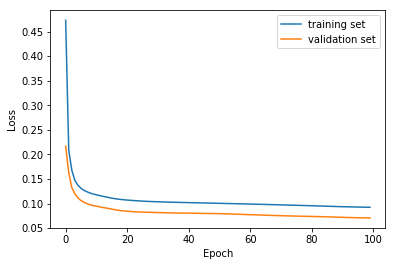

In [50]:
# Plot the loss
plt.figure()
plt.plot(estim.train_losses, label='training set')
plt.plot(estim.valid_losses, label='validation set')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.xlim(195,300)
#plt.ylim(.06,.08)
plt.legend(loc=0);

## Evaluate model on the test set

In [16]:
if cuda:
    torch.cuda.empty_cache()

In [23]:
estim.load_checkpoint('Trainings/hid8l15*5v2.pt')

In [51]:
# prepare test generator
with torch.no_grad():
    test_batcher = batch_generator(test_graphs, n_samples=n_test, batch_size=1, train=False)
    test_outputs = estim.predict(test_batcher, n_test_batches, concat=False)
    test_preds = [torch_to_np(o) for o in test_outputs]

    # Flatten the predictions and labels
    flat_y = np.concatenate([g.y.flatten() for g in test_graphs])
    flat_pred = np.concatenate([p.flatten() for p in test_preds])
    print(flat_y.shape)
    print(flat_pred.shape)

(702769,)
(702769,)


In [19]:
def makeROC(flat_y, flat_pred, thresh=0.5):
    
    print('Test set results with threshold of', thresh)
    print('Accuracy:  %.4f' % sklearn.metrics.accuracy_score(flat_y, flat_pred>thresh))
    print('Precision: %.4f' % sklearn.metrics.precision_score(flat_y, flat_pred>thresh))
    print('Recall:    %.4f' % sklearn.metrics.recall_score(flat_y, flat_pred>thresh))
    
    # Compute the ROC curve
    fpr, tpr, _ = sklearn.metrics.roc_curve(flat_y, flat_pred)
    
    plt.figure(figsize=(9,2))

    # Plot the model outputs
    plt.subplot(131)
    binning=dict(bins=50, range=(0,1), histtype='bar')
    plt.hist(flat_pred[flat_y<thresh], label='fake', **binning)
    plt.hist(flat_pred[flat_y>thresh], label='true', **binning)
    #plt.xlim(.1,.125)
    plt.xlabel('Model output')
    plt.legend(loc=0)

    # Plot the ROC curve
    plt.subplot(132)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], '--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')

    # Plot the ROC curve
    plt.subplot(133)
    plt.semilogx(fpr, tpr)
    #plt.plot([0, 1], [0, 1], '--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.xlim(0, 1)
    plt.title('ROC curve')

    plt.tight_layout()

Test set results with threshold of 0.5
Accuracy:  0.9539
Precision: 0.9407
Recall:    0.9308


/home/ec2-user/miniconda3/envs/pytorch-training/lib/python3.6/site-packages/matplotlib/axes/_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


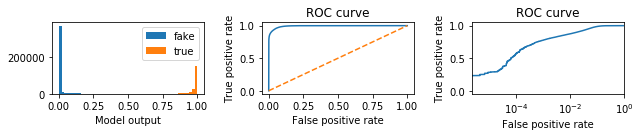

In [52]:
#after training
makeROC(flat_y, flat_pred)

In [22]:
#mask

threshold = .005
%matplotlib inline

def summer(arr, net_name):
    arr_f = arr.flatten()
    sum_n = sum(arr_f)
    print(net_name, 'Network Sum:', sum_n)

with torch.no_grad():
    # Edge Networks
    #print(model.edge_network.network[0].weight)
    print(model.edge_network.network[0].weight.shape)
    arr_e = torch_to_np(model.edge_network.network[0].weight)
    arr_e = (np.abs(arr_e) > threshold)*1
    summer(arr_e, 'Edge')
    # mask
    masked_weight = torch.nn.Parameter(model.edge_network.network[0].weight * np_to_torch(arr_e))
    model.edge_network.network[0].weight = masked_weight
    print(model.edge_network.network[0].weight)

    #arr_e2 = torch_to_np(model.edge_network.network[2].weight)
    print(model.edge_network.network[2].weight.shape)
    # Original size = 32
    arr_e2 = (np.abs(arr_e2) > threshold)*1
    summer(arr_e2, 'Edge2')
    # mask
    masked_weight = torch.nn.Parameter(model.edge_network.network[2].weight * np_to_torch(arr_e2))
    model.edge_network.network[2].weight = masked_weight
    
    # Node Networks
    #arr_n = torch_to_np(model.node_network.network[0].weight)
    print(model.node_network.network[0].weight.shape)
    arr_n = (np.abs(arr_n) > threshold)*1
    summer(arr_n, 'Node')
    # mask
    masked_weight = torch.nn.Parameter(model.node_network.network[0].weight * np_to_torch(arr_n))
    model.node_network.network[0].weight = masked_weight
    
    arr_n2 = torch_to_np(model.node_network.network[2].weight)
    #print(model.node_network.network[2].weight.shape)
    arr_n2 = (np.abs(arr_n2) > threshold)*1
    summer(arr_n2, 'Node2')
    # mask
    masked_weight = torch.nn.Parameter(model.node_network.network[2].weight * np_to_torch(arr_n2))
    model.node_network.network[2].weight = masked_weight

torch.Size([8, 22])
Edge Network Sum: 93
Parameter containing:
tensor([[-2.1304, -0.0516,  0.0126, -0.8568, -0.8621, -0.9770, -0.9769,
         -3.0272, -0.1467,  3.3401, -0.0000,  2.1391,  0.2187,  0.9900,
          0.9963,  0.1534,  1.6787,  1.3115,  2.3903, -0.5635, -3.4897,
          0.0000],
        [-1.3893, -0.2929,  0.0000, -1.3161, -1.5708, -0.6040, -0.9857,
         -1.9054, -0.0000,  2.3552,  0.0000,  2.4286,  0.4279,  0.6131,
         -0.2298,  0.6291,  2.1553,  1.7994,  0.0233,  1.1532, -2.7646,
          0.0000],
        [-0.0117,  1.6870, -0.0300,  0.0000, -0.0000, -0.0000,  0.0000,
          0.0287, -0.0000, -0.0000,  0.0000, -0.0360,  0.5739, -0.0000,
         -0.0923,  0.0000, -0.0076,  0.0000,  0.0000, -0.0000, -0.0000,
          0.0000],
        [-0.0000,  0.0000,  0.0000,  0.0000, -0.0000,  0.0000, -0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0000, -0.0000,
          0.0000,  0.0000,  0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
         -0.0000

In [45]:
#weights

threshold = .01
%matplotlib inline

def summer(arr, net_name):
    arr_f = arr.flatten()
    sum_n = sum(arr_f)
    print(net_name, 'Network Sum:', sum_n)

with torch.no_grad():
    # Edge Networks
    print(model.edge_network.network[0].weight.shape)
    arr_e = torch_to_np(model.edge_network.network[0].weight)
    arr_e = (np.abs(arr_e) > threshold)*1
    summer(arr_e, 'Edge')

    arr_e2 = torch_to_np(model.edge_network.network[2].weight)
    print(model.edge_network.network[2].weight.shape)
    # Original size = 32
    arr_e2 = (np.abs(arr_e2) > threshold)*1
    summer(arr_e2, 'Edge2')
    
    # Node Networks
    arr_n = torch_to_np(model.node_network.network[0].weight)
    print(model.node_network.network[0].weight.shape)
    arr_n = (np.abs(arr_n) > threshold)*1
    summer(arr_n, 'Node')
    print(model.node_network.network[0].weight)
    
    arr_n2 = torch_to_np(model.node_network.network[2].weight)
    print(model.node_network.network[2].weight.shape)
    arr_n2 = (np.abs(arr_n2) > threshold)*1
    summer(arr_n2, 'Node2')

torch.Size([8, 22])
Edge Network Sum: 86
torch.Size([1, 8])
Edge2 Network Sum: 8
torch.Size([8, 33])
Node Network Sum: 183
Parameter containing:
tensor([[ 0.0013, -0.0000,  0.1485,  0.1057,  0.2001,  0.0000,  0.1147,
         -0.1432, -0.0520,  0.0672, -0.0000, -0.0420, -0.0382, -0.0000,
          0.0000, -0.0129,  0.0956,  0.0221, -0.0073, -0.0075,  0.0003,
          0.0000,  0.0548,  0.1839,  0.2307,  0.0081,  0.2903,  0.0661,
         -0.3948, -0.0170, -0.3651, -0.2648, -0.0000],
        [ 0.1212,  0.0173,  0.0574, -0.0174, -0.1010, -0.1026,  0.2197,
          0.0000,  0.1542,  0.0148,  0.0000,  0.0000,  0.0264, -0.0778,
          0.1616, -0.0000, -0.1111,  0.0112,  0.0284,  0.0078,  0.0000,
          0.0000,  0.3083,  0.0160, -0.8809, -0.5331,  0.8116, -0.5660,
          0.1200, -0.2023, -0.0222, -0.0004,  0.0000],
        [-0.0000,  0.0032, -0.1245,  0.0108, -0.0333,  0.0703,  0.0264,
         -0.1277,  0.0000, -0.0329,  0.0000, -0.0227,  0.0191, -0.0248,
          0.0207, -0.0012

In [23]:
%matplotlib inline
 
def plotLayerWeights(layer, plotTitle='Network'):
    with torch.no_grad():
        
        test_batcher = batch_generator(test_graphs, n_samples=1, batch_size=batch_size, train=False)
        test_outputs = estim.predict(test_batcher, 1, concat=False)
        arr = torch_to_np(layer.weight)
        arr = arr.flatten()
        print(arr)

        plt.figure(figsize=(4,4))

        #plt.subplot(2,2,1)
    
        #plt.hist(arr, bins=100, range=(-.0002,.0002))
        #plt.xlabel('Weight')
        #plt.ylabel('Frequency')
        #plt.title('Network')

        #plt.subplot(2,2,2)
        #plt.hist(np.abs(arr), bins=100, range=(0,.0002))
        #plt.xlabel('|Weight|')
        #plt.ylabel('Frequency')
        #plt.title('Network-Absolute Value')

        #plt.subplot(2,2,3)
        #plt.hist(np.abs(arr), bins=1000, range=(2**-11, 2**-0))
        #plt.xscale('log',basex=2)
        #plt.xlim([2**-13,2**-4])
        #plt.xlabel('Weight')
        #plt.ylabel('Frequency')
        #plt.title('Network-Log2')
    
        #plt.subplot(2,2,4)
        #arr_n = [np.log(x) for x in arr_n]
        logbins = np.geomspace(10**-7, 10, 75)
        plt.hist(np.abs(arr), logbins)
        plt.xscale('log',basex=10)
        plt.xlabel('|Weight|')
        plt.ylabel('Frequency')
        plt.title(plotTitle)

        plt.show()
#print(model.edge_network.network[0].get_mask())
#print(model.edge_network.network[0].weight.data)

In [61]:
estim.load_weights('Trainings/hid8l153mask0_ldweights.pt')

[-0.2785388  -0.87754077  0.07701816  0.7265228   0.07518622 -0.04129204
  0.8601666   0.0710003   0.00744797  0.5785742  -0.27698344  0.01626202
  0.04030793 -0.341406    0.01566464  0.20478721 -1.0073024   0.00811465
  0.51093817 -0.54708827 -0.01368114  0.22488846 -0.8249202  -0.03246367]


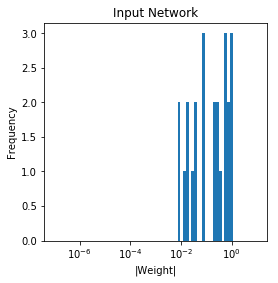

[-1.75304186e+00  8.00293148e-01  1.09672053e-02 -8.75387371e-01
 -8.66540492e-01 -5.56144059e-01 -9.24409866e-01 -3.38338208e+00
  3.46691124e-02  5.32981968e+00 -0.00000000e+00  2.03256750e+00
 -3.35380673e-01  9.95464504e-01  6.33799136e-01  4.46935177e-01
  1.86809897e+00  1.59372044e+00  2.61703348e+00 -2.94476658e-01
 -5.03864050e+00  0.00000000e+00 -1.79837000e+00 -1.25919592e+00
  0.00000000e+00 -8.93906832e-01 -1.92607331e+00  5.98742394e-03
 -1.31473649e+00 -1.49626970e+00 -0.00000000e+00  4.91947937e+00
  0.00000000e+00  1.79772627e+00  1.58674800e+00  6.90678596e-01
  1.60663277e-01  9.36647296e-01  1.77766943e+00  2.25670075e+00
  3.65416519e-04  5.80058433e-04 -5.13477850e+00  0.00000000e+00
  5.91720402e-01 -4.62673046e-03 -1.21297371e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.11831643e-01
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -3.35074514e-01  0.00000

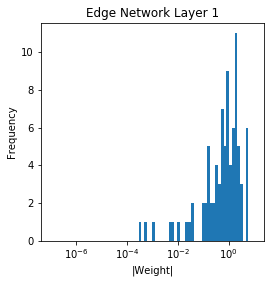

[11.016977   9.534442   5.970725   2.418292  -0.9939551  6.043885
 -6.721974  15.248678 ]


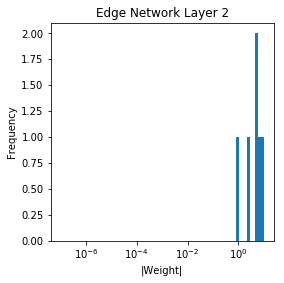

[ 0.00000000e+00 -0.00000000e+00  1.44321978e-01  5.74620627e-02
  6.43335632e-04  0.00000000e+00  2.63294056e-02 -1.26050338e-02
 -9.84561164e-03 -1.61532369e-02 -0.00000000e+00 -8.04085881e-02
  1.39772240e-02 -0.00000000e+00  0.00000000e+00  6.06424138e-02
  1.36430070e-01 -2.40673702e-02 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -5.42613119e-02  2.14208379e-01
  9.37320471e-01  0.00000000e+00  3.76775742e-01  3.19460154e-01
  2.79808134e-01  3.48306149e-01 -6.30227253e-02  2.59316504e-01
 -0.00000000e+00  3.75746898e-02 -4.02837172e-02  1.53843984e-01
 -1.75657421e-01 -1.46706343e-01 -8.07199851e-02  1.32698640e-01
  0.00000000e+00  3.92620414e-02 -8.99876580e-02  0.00000000e+00
  0.00000000e+00  2.48595700e-02 -3.59033570e-02 -8.84429924e-03
 -0.00000000e+00 -5.80839552e-02  1.08532228e-01 -2.96569453e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  2.85245031e-01
  9.39919986e-03 -8.71540666e-01 -6.44325614e-01  6.25766039e-01
 -5.31304598e-01  1.72072

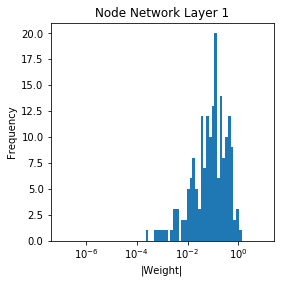

[-6.47105277e-03  0.00000000e+00  4.43279356e-01  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  1.62765551e+00  9.35034826e-03
  3.18679839e-01  1.50462076e-01 -8.37341309e-01  3.17765385e-01
  1.45442688e+00  9.42006469e-01  2.43567362e-01  4.92402762e-01
  2.08976679e-02 -2.16616333e-01  2.47211471e-01  3.27008963e-01
  8.66434351e-02 -5.64189279e-04  1.77967548e-02 -4.78420317e-01
  6.75561845e-01 -1.10055077e+00  1.65742740e-01  7.84804344e-01
  0.00000000e+00 -4.65097219e-01  1.33141875e-02  7.39803553e-01
  7.89457083e-01  7.04089105e-01 -1.19982958e-02  2.71949112e-01
  9.37082291e-01 -1.68467849e-01  8.09299588e-01  2.12779269e-01
  6.09151423e-01  9.66031998e-02  6.19828165e-01 -1.18052259e-01
  0.00000000e+00  2.06477270e-01  5.84843040e-01 -2.59615123e-01
  6.57613635e-01 -0.00000000e+00  8.53206515e-01 -2.51102507e-01
  6.42910719e-01  8.34006369e-02  0.00000000e+00  2.75442868e-01
  1.33487180e-01 -3.93897906e-04  1.34825659e+00 -3.53330135e-01
 -3.63013148e-01 -2.86298

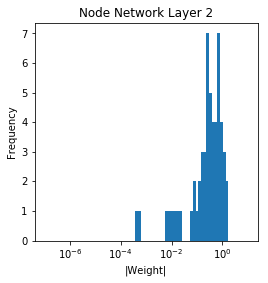

In [53]:
## NETWORKS 
plotLayerWeights(model.input_network[0], plotTitle='Input Network')
plotLayerWeights(model.edge_network.network[0], plotTitle='Edge Network Layer 1')
plotLayerWeights(model.edge_network.network[2], plotTitle='Edge Network Layer 2')
plotLayerWeights(model.node_network.network[0], plotTitle='Node Network Layer 1')
plotLayerWeights(model.node_network.network[2], plotTitle='Node Network Layer 2')

## Visualize some samples

In [ ]:
# Draw some samples
for i in range(4):
    print('accuracy %.3f, precision %.3f, recall %.3f' % (
        sklearn.metrics.accuracy_score(test_y[i], test_pred[i]>thresh),
        sklearn.metrics.precision_score(test_y[i], test_pred[i]>thresh),
        sklearn.metrics.recall_score(test_y[i], test_pred[i]>thresh)))
    draw_sample(test_X[i]*feature_scale, test_Ri[i], test_Ro[i], test_pred[i], alpha_labels=True);

## Visualize evolution of graph iterations

Let's take a sample and pull out the intermediate edge scores during graph iterations.
I'd like to visualize how the model converges on its chosen edges.

In [ ]:
def graph_iter(model, X, H, Ri, Ro):
    # Shortcut connections
    H = torch.cat([H, X], dim=-1)
    # Edge network
    e = model.edge_network(H, Ri, Ro)
    # Node network
    H = model.node_network(H, e, Ri, Ro)
    return e, H

In [ ]:
batcher = batch_generator(test_X, test_Ri, test_Ro, test_y, train=False,
                          n_samples=1, batch_size=1)

In [ ]:
model = estim.model

In [ ]:
# Pull the inputs from the batcher
(X, Ri, Ro), y = next(batcher)

In [ ]:
# Apply input network
with torch.no_grad():
    H = model.input_network(X)

    for i in range(model.n_iters + 1):
        # Apply an iteration of the graph
        e, H = graph_iter(model, X, H, Ri, Ro)

        # Draw the edges
        draw_sample(torch_to_np(X)[0]*feature_scale,
                    torch_to_np(Ri)[0], torch_to_np(Ro)[0],
                    torch_to_np(e)[0], alpha_labels=True)

## Discussion

On 10 tracks and 10 barrel layers, the performance is great!